In [1]:
%matplotlib inline


import json
import pandas as pd


results = "latest.txt"

In [2]:
rows = []

with open(results) as fh:
    for line in fh:
        """{
            "level": "INFO",
            "message": "generating operation mix",
            "span": {
                "mix": "Mix { read: 94, insert: 2, remove: 1, update: 3, upsert: 0 }",
                "name": "benchmark",
                "threads": 1
            },
            "spans": [
                {
                    "name": "task",
                    "task": "read_heavy"
                },
                {
                    "name": "trial_num",
                    "trial_num": 0
                },
                {
                    "kind": "main::adapters::ContrieTable<u64>",
                    "name": "kind"
                },
                {
                    "mix": "Mix { read: 94, insert: 2, remove: 1, update: 3, upsert: 0 }",
                    "name": "benchmark",
                    "threads": 1
                }
            ],
            "target": "bustle",
            "timestamp": "Aug 19 13:25:47.159"
        }"""
        line = json.loads(line)
        if line.get("avg") == None: continue
        
        rows.append({
            "timestamp": line["timestamp"],
            "impl": line["spans"][2]["kind"],
            "task": line["spans"][0]["task"],
            "trial": line["spans"][1]["trial_num"],
            "threads": line["span"]["threads"],
            "mix": line["span"]["mix"],
            "avg": int(line["avg"].strip('ns')),
            "ops": line["ops"],
            "took": line["took"],
            "_debug": line["message"]  
        })
        
df = pd.DataFrame.from_records(rows)

In [3]:
df.head()

,timestamp,impl,task,trial,threads,mix,avg,ops,took,_debug
0,Aug 19 15:46:07.578,main::adapters::ContrieTable<u64>,write_heavy,0,1,"Mix { read: 10, insert: 80, remove: 0, update:...",553,25165824,13.933456053s,workload mix finished
1,Aug 19 15:46:49.456,main::adapters::ContrieTable<u64>,write_heavy,0,2,"Mix { read: 10, insert: 80, remove: 0, update:...",263,25165824,6.633428638s,workload mix finished
2,Aug 19 15:47:25.298,main::adapters::ContrieTable<u64>,write_heavy,0,3,"Mix { read: 10, insert: 80, remove: 0, update:...",173,25165824,4.378883573s,workload mix finished
3,Aug 19 15:47:59.058,main::adapters::ContrieTable<u64>,write_heavy,0,4,"Mix { read: 10, insert: 80, remove: 0, update:...",135,25165824,3.421839441s,workload mix finished
4,Aug 19 15:48:31.212,main::adapters::ContrieTable<u64>,write_heavy,0,5,"Mix { read: 10, insert: 80, remove: 0, update:...",106,25165824,2.681038835s,workload mix finished


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


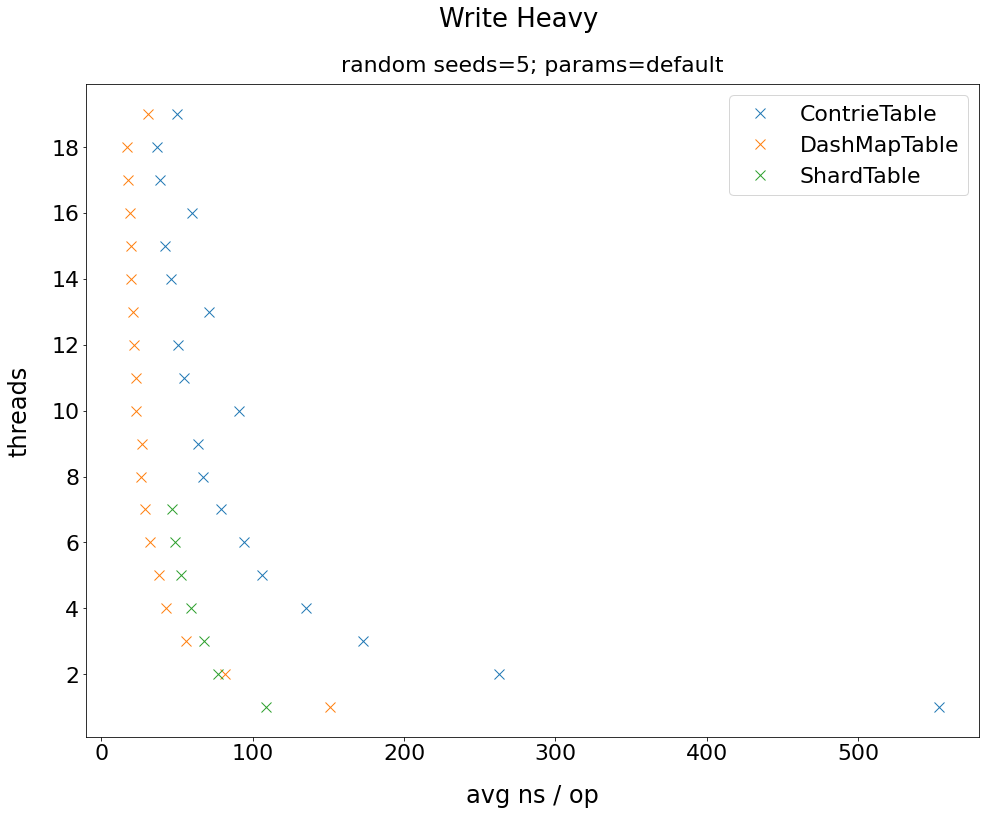

In [4]:
import matplotlib.pyplot as plt
import matplotlib


font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)

fig, ax = plt.subplots(figsize=(16,12))

df = df[df['impl'] != 'main::adapters::CHashMapTable<u64>']
df = df[df['impl'] != 'main::adapters::MutexStdTable<u64>']

title_set = False

for task, task_df in df.groupby('task'):
    for label, group in task_df.groupby('impl'):
        see = group[['threads', 'avg']]
        see = see.groupby('threads').mean().reset_index()
        see.plot(
            x="avg", 
            y="threads", 
            ax=ax, 
            label=label.strip("main::adapters::").strip("<u64>"), 
    #        title=f"Average Performance ({task})", 
            style='x', # '.--'
            ms=10
        )
    
    yticks = list(filter(lambda x: x % 2 == 0, list(df["threads"].unique())))
    
    
    title_string = task.replace("_", " ")
    title_string = title_string.title()
    subtitle_string = f"random seeds={5}; params=default"
    
    if not title_set:
        plt.suptitle(title_string, y=0.97, fontsize=26)
        title_set = True
        
    plt.title(subtitle_string, y=1.01, fontsize=22) #, fontsize=10)
    
    ax.set_yticks(yticks)
    ax.set_ylabel("threads", fontsize=24, labelpad=20)
    ax.set_xlabel("avg ns / op", fontsize=24, labelpad=20)
    plt.legend()
    plt.savefig(f"avg_performance_{task}.png")
    plt.show()
